In [1]:
import boilerplate
import graphviz

import pyrtl
from pyrtl import *

import z3

In [ ]:
def net_to_smt(wb):
    """
    Convert PyRTL working block to SMT formulas for Z3 verification.
    
    Returns:
    - wires: dict mapping wire names to Z3 BitVec variables
    - ops: list of Z3 operations/constraints 
    - assertions: list of Z3 assertions representing the circuit logic
    """
    
    wires = {}
    ops = []
    assertions = []
    
    # First pass: create Z3 BitVec variables for all wires
    for net in wb:
        # Create BitVec for destination wires
        for dest in net.dests:
            if dest.name not in wires:
                wires[dest.name] = z3.BitVec(dest.name, dest.bitwidth)
        
        # Create BitVec for argument wires (inputs)
        for arg in net.args:
            if arg.name not in wires:
                wires[arg.name] = z3.BitVec(arg.name, arg.bitwidth)
    
    # Second pass: create Z3 constraints based on operations
    for net in wb:
        op = net.op
        args = [wires[arg.name] for arg in net.args]
        dest = wires[net.dests[0].name]  # Most operations have single destination
        
        match op:
            case 'w': # Wire assignment
                # TODO wire width adaption
                assertions.append(z3.eq(dest.bitwidth, args[0].bitwidth))

                assertion = z3.eq(dest, args[0])
                assertions.append(assertion)
                ops.append(('assign', args[0], dest))
            
            case '&':  # Bitwise AND
                if len(args) == 2:
                    # TODO assert input width are same
                    assertions.append(z3.And(z3.eq(args[0].bitwidth, args[1].bitwidth),
                                             z3.eq(dest.bitwidth, args[0])))
                    
                    assertion = z3.eq(dest, z3.And(args[0], args[1]))
                    assertions.append(assertion)
                    ops.append(('and', args[0], args[1], dest))
            
            case '|':  # Bitwise OR
                if len(args) == 2:
                    # TODO assert input width are same
                    assertions.append(z3.And(z3.eq(args[0].bitwidth, args[1].bitwidth),
                                             z3.eq(dest.bitwidth, args[0])))
                    
                    assertion = z3.eq(dest, z3.Or(args[0], args[1]))
                    assertions.append(assertion)
                    ops.append(('or', args[0], args[1], dest))
                    
            case '^':  # Bitwise XOR
                if len(args) == 2:
                    # TODO assert input width are same
                    assertions.append(z3.And(z3.eq(args[0].bitwidth, args[1].bitwidth),
                                             z3.eq(dest.bitwidth, args[0].bitwidth)))

                    assertion = z3.eq(dest, z3.Xor(args[0], args[1]))
                    assertions.append(assertion)
                    ops.append(('xor', args[0], args[1], dest))
                    
            case '~':  # Bitwise NOT
                # assert input and output widths match
                assertions.append(z3.eq(dest.bitwidth, args[0]))
                
                assertion = z3.eq(dest, z3.Not(args[0]))
                assertions.append(assertion)
                ops.append(('not', args[0], dest))
                
            case 'c':  # Concatenation
                # Concatenate arguments from left to right (most significant first)
                if len(args) >= 2:
                    result = args[0]
                    result_bitwidth = 0
                    for i in range(1, len(args)):
                        result = z3.Concat(result, args[i])
                        result_bitwidth += args[1].bitwidth

                    # TODO assert dest width is the sum of the input widths
                    assertions.append(z3.eq(dest.bitwidt, result_bitwidth))

                    assertion = z3.eq(dest, result)
                    assertions.append(assertion)
                    ops.append(('concat', args, dest))
                    
            case 's':  # Select/Extract bits
                # Format: select(wire, high_bit, low_bit)
                if len(args) == 1 and net.op_param is not None:
                    if isinstance(net.op_param, tuple) and len(net.op_param) == 2:
                        high_bit, low_bit = net.op_param

                        # TODO assert dest width is highbit-lowbit+1
                        assertions.append(z3.eq(dest.bitwidth, (high_bit - low_bit + 1)))

                        assertion = z3.eq(dest, z3.Extract(high_bit, low_bit, args[0]))
                        assertions.append(assertion)
                        ops.append(('extract', args[0], high_bit, low_bit, dest))
                        
            case 'm':  # Multiplexer
                # Format: mux(select, *options)
                if len(args) >= 3:
                    select = args[0]
                    options = args[1:]
                    # Build nested if-then-else for mux
                    result = options[-1]  # default case
                    for i in range(len(options)-2, -1, -1):
                        condition = z3.eq(select, i)
                        result = z3.If(condition, options[i], result)
                    assertion = z3.eq(dest, result)
                    assertions.append(assertion)
                    ops.append(('mux', select, options, dest))
                    
            case '*':
                if len(args) == 2:
                    # TODO assert dest width 2*n than the input width n
                    assertions.append(z3.And(z3.eq(args[0].bitwidth, args[1].bitwidth),
                                             z3.eq(dest.bitwidth, args[0] * 2)))
                    
                    assertion = z3.eq(dest, args[0] * args[1])
                    assertions.append(assertion)
                    ops.append(('mul', args[0], args[1], dest))

            case '+':  # Addition
                if len(args) == 2:
                    # TODO assert dest width is one bit more than the input width
                    assertions.append(z3.And(z3.eq(args[0].bitwidth, args[1].bitwidth),
                                             z3.eq(dest.bitwidth, args[0] + 1)))
                    
                    assertion = z3.eq(dest, (args[0] + args[1]))
                    assertions.append(assertion)
                    ops.append(('add', args[0], args[1], dest))
                    
            case '-':  # Subtraction
                if len(args) == 2:
                    # TODO assert dest width is one bit more than the input width
                    assertions.append(z3.And(z3.eq(args[0].bitwidth, args[1].bitwidth),
                                             z3.eq(dest.bitwidth, args[0] + 1)))
                    
                    assertion = z3.eq(dest, (args[0] - args[1]))
                    assertions.append(assertion)
                    ops.append(('sub', args[0], args[1], dest))
                    
            case '=':  # Equality comparison
                if len(args) == 2:
                    assertion = z3.eq(dest, z3.If(z3.eq(args[0], args[1]), 
                                                  z3.BitVecVal(1, dest.size()), 
                                                  z3.BitVecVal(0, dest.size())))
                    assertions.append(assertion)
                    ops.append(('eq', args[0], args[1], dest))
                    
            case '<':  # Less than comparison
                if len(args) == 2:
                    assertion = z3.eq(dest, z3.If(z3.ULT(args[0], args[1]), 
                                                  z3.BitVecVal(1, dest.size()), 
                                                  z3.BitVecVal(0, dest.size())))
                    assertions.append(assertion)
                    ops.append(('lt', args[0], args[1], dest))                    

            case _:
                # Unknown operation - to handle unsupported ops
                ops.append(('unknown_op', op, net.op_param, args, dest))
    
    return wires, ops, assertions

## Verifying a Boolean circuit

In [5]:
reset_working_block()

r = [Input(bitwidth=1, name="r%d"%i) for i in range(2)]
out = Output(bitwidth=2, name="out")

out <<= concat(r[0] & r[1], r[0] ^ r[1])

wires, ops, assertions = net_to_smt(working_block())
working_block()

AttributeError: 'BitVecRef' object has no attribute 'bitwidth'

In [12]:
print(wires)
print(ops)
print(assertions)

{'tmp10': tmp10, 'r0': r0, 'r1': r1, 'tmp9': tmp9, 'tmp11': tmp11, 'out': out}
[('xor', r0, r1, tmp10), ('and', r0, r1, tmp9), ('concat', [tmp9, tmp10], tmp11), ('assign', tmp11, out)]
[tmp10 == r0 ^ r1, tmp9 == r0 & r1, tmp11 == Concat(tmp9, tmp10), out == tmp11]


In [13]:
sim = Simulation()
sim.step({r[0]: 1, r[1]: 0})
sim.inspect(out)

1

In [14]:
from z3 import BitVec, And, Xor, BV2Int

r = [BitVec("r0", 1), BitVec("r1", 1)]
out = BitVec("out", 2)

system = [
    out == z3.Concat(r[0] & r[1], r[0] ^ r[1])
]

spec = BV2Int(r[0]) + BV2Int(r[1]) == BV2Int(out)

s = z3.Solver()
s.add(system)
s.add(z3.Not(spec))
res = s.check()
s.model() if res == z3.sat else res

unsat

In [15]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])

^  [('r0', 1), ('r1', 1)] [('tmp10', 1)]
&  [('r0', 1), ('r1', 1)] [('tmp9', 1)]
c  [('tmp9', 1), ('tmp10', 1)] [('tmp11', 2)]
w  [('tmp11', 2)] [('out', 2)]


_Exercise_. We would like to generate `spec` automatically from the net elements in the hardware design.
Write a loop that constructs such a formula.

In [27]:
# go for it


In [16]:
reset_working_block()

_r = [Input(bitwidth=2, name="r%d"%i) for i in range(2)]
out = Output(bitwidth=3, name="out")

r = [[_r[0][0], _r[0][1]], [_r[1][0], _r[1][1]]]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

out <<= concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0])

In [21]:
wires, ops, assertions = net_to_smt(working_block())

print(wires)
print(ops)
print(assertions)

{'tmp13': tmp13, 'r0': r0, 'tmp12': tmp12, 'tmp15': tmp15, 'r1': r1, 'tmp14': tmp14, 'tmp17': tmp17, 'tmp19': tmp19, 'tmp21': tmp21, 'tmp23': tmp23, 'tmp16': tmp16, 'tmp18': tmp18, 'tmp22': tmp22, 'tmp20': tmp20, 'tmp24': tmp24, 'out': out}
[('or', tmp13, tmp15, tmp17), ('and', tmp13, tmp15, tmp19), ('xor', tmp13, tmp15, tmp21), ('xor', tmp12, tmp14, tmp23), ('and', tmp12, tmp14, tmp16), ('and', tmp16, tmp17, tmp18), ('xor', tmp21, tmp16, tmp22), ('or', tmp18, tmp19, tmp20), ('concat', [tmp20, tmp22, tmp23], tmp24), ('assign', tmp24, out)]
[tmp17 == tmp13 | tmp15, tmp19 == tmp13 & tmp15, tmp21 == tmp13 ^ tmp15, tmp23 == tmp12 ^ tmp14, tmp16 == tmp12 & tmp14, tmp18 == tmp16 & tmp17, tmp22 == tmp21 ^ tmp16, tmp20 == tmp18 | tmp19, tmp24 == Concat(Concat(tmp20, tmp22), tmp23), out == tmp24]


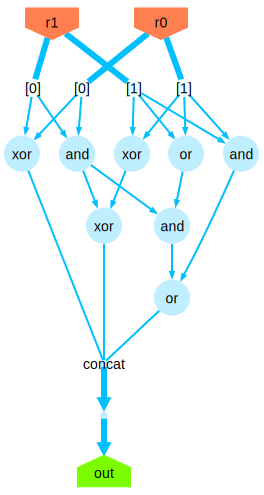

In [17]:
working_block()

In [20]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])


s (1,) [('r0', 2)] [('tmp13', 1)]
s (0,) [('r0', 2)] [('tmp12', 1)]
s (1,) [('r1', 2)] [('tmp15', 1)]
s (0,) [('r1', 2)] [('tmp14', 1)]
|  [('tmp13', 1), ('tmp15', 1)] [('tmp17', 1)]
&  [('tmp13', 1), ('tmp15', 1)] [('tmp19', 1)]
^  [('tmp13', 1), ('tmp15', 1)] [('tmp21', 1)]
^  [('tmp12', 1), ('tmp14', 1)] [('tmp23', 1)]
&  [('tmp12', 1), ('tmp14', 1)] [('tmp16', 1)]
&  [('tmp16', 1), ('tmp17', 1)] [('tmp18', 1)]
^  [('tmp21', 1), ('tmp16', 1)] [('tmp22', 1)]
|  [('tmp18', 1), ('tmp19', 1)] [('tmp20', 1)]
c  [('tmp20', 1), ('tmp22', 1), ('tmp23', 1)] [('tmp24', 3)]
w  [('tmp24', 3)] [('out', 3)]


#### Verifying
_Following is a manual translation of the circuit into a Boolean formula._

In [22]:
from z3 import BitVec, BV2Int

_r = [BitVec('r%i'%i, 2) for i in range(2)]
out = BitVec('out', 3)

r = [[z3.Extract(i, i, b) for i in range(2)] for b in _r]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

s = z3.Solver()
s.add(out == z3.Concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0]))

In [23]:
s

[out ==
 Concat(Concat(Extract(0, 0, r0) &
               Extract(0, 0, r1) &
               (Extract(1, 1, r0) | Extract(1, 1, r1)) |
               Extract(1, 1, r0) & Extract(1, 1, r1),
               Extract(1, 1, r0) ^
               Extract(1, 1, r1) ^
               Extract(0, 0, r0) & Extract(0, 0, r1)),
        Extract(0, 0, r0) ^ Extract(0, 0, r1))]

In [24]:
from z3 import BitVec, BV2Int

_r = [BitVec('r%i'%i, 2) for i in range(2)]
out = BitVec('out', 3)

r = [[z3.Extract(i, i, b) for i in range(2)] for b in _r]

c = [r[0][0] & r[1][0]]
c.append(c[0] & (r[0][1] | r[1][1]) | r[0][1] & r[1][1])

s = z3.Solver()
s.add(out == z3.Concat(c[1], r[0][1] ^ r[1][1] ^ c[0], r[0][0] ^ r[1][0]))

In [25]:
#s.add(_r[0] != 0)
s.check()
s.model()

[r0 = 0, r1 = 0, out = 0]

In [26]:
res = s.check([z3.Not(BV2Int(_r[0]) + BV2Int(_r[1]) == BV2Int(out))])
res

unsat

_Implement a function_ `net_to_smt` _that will do the same (or equivalent) translation automatically._

In [27]:
#from circuit import net_to_smt

wires, ops, assertions = net_to_smt(wb)

s = z3.Solver()
for phi in assertions:
    print(phi)
    s.add(phi)

tmp17 == tmp13 | tmp15
tmp19 == tmp13 & tmp15
tmp21 == tmp13 ^ tmp15
tmp23 == tmp12 ^ tmp14
tmp16 == tmp12 & tmp14
tmp18 == tmp16 & tmp17
tmp22 == tmp21 ^ tmp16
tmp20 == tmp18 | tmp19
tmp24 == Concat(Concat(tmp20, tmp22), tmp23)
out == tmp24


In [29]:
res = s.check([z3.Not(BV2Int(wires['r0']) + BV2Int(wires['r1']) == BV2Int(wires['out']))])
res

sat

In [30]:
s.model() if res == z3.sat else None

[tmp24 = 5,
 r0 = 1,
 r1 = 3,
 tmp18 = 0,
 tmp15 = 1,
 tmp20 = 1,
 tmp13 = 1,
 tmp16 = 0,
 tmp19 = 1,
 tmp22 = 0,
 tmp17 = 1,
 tmp14 = 0,
 out = 5,
 tmp23 = 1,
 tmp21 = 0,
 tmp12 = 1]

## Verify something with memory?

In [31]:
reset_working_block()

sp = Register(bitwidth=3, name='sp')
mem = MemBlock(bitwidth=3, addrwidth=3, name='mem', max_write_ports=2)

mem[sp] <<= (mem[sp] + 1)[:3]
mem[0] <<= 0
sp.next <<= sp + 1

In [32]:
sim_trace = pyrtl.SimulationTrace()
sim = pyrtl.Simulation(tracer=sim_trace)
for cycle in range(13):
    sim.step({})

sim_trace.render_trace()

<IPython.core.display.Javascript object>

In [33]:
sim.inspect_mem(mem)

{0: 0, 1: 2, 2: 2, 3: 2, 4: 2, 5: 1, 6: 1, 7: 1}

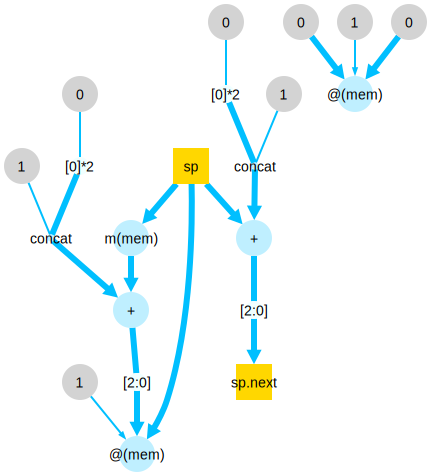

In [34]:
working_block()

In [35]:
wb = working_block()
for net in wb:
    print(net.op, net.op_param or '', [(a.name, a.bitwidth) for a in net.args], [(a.name, a.bitwidth) for a in net.dests])

s (0, 0) [('const_1_0', 1)] [('tmp26', 2)]
m (0, <pyrtl.memory.MemBlock object at 0x000001EEDAA31C10>) [('sp', 3)] [('tmp25', 3)]
@ (0, <pyrtl.memory.MemBlock object at 0x000001EEDAA31C10>) [('const_4_0', 3), ('const_6_0', 3), ('const_5_1', 1)] []
s (0, 0) [('const_8_0', 1)] [('tmp30', 2)]
c  [('tmp30', 2), ('const_7_1', 1)] [('tmp31', 3)]
c  [('tmp26', 2), ('const_0_1', 1)] [('tmp27', 3)]
+  [('tmp25', 3), ('tmp27', 3)] [('tmp28', 4)]
+  [('sp', 3), ('tmp31', 3)] [('tmp32', 4)]
s (0, 1, 2) [('tmp28', 4)] [('tmp29', 3)]
@ (0, <pyrtl.memory.MemBlock object at 0x000001EEDAA31C10>) [('sp', 3), ('tmp29', 3), ('const_2_1', 1)] []
s (0, 1, 2) [('tmp32', 4)] [('tmp33', 3)]
r  [('tmp33', 3)] [('sp', 3)]


In [36]:
list(wb)

[LogicNet(op='s', op_param=(0, 0), args=(<pyrtl.wire.Const object at 0x000001EEDAA30E60>,), dests=(<pyrtl.wire.WireVector object at 0x000001EEDAA30680>,)),
 LogicNet(op='m', op_param=(0, <pyrtl.memory.MemBlock object at 0x000001EEDAA31C10>), args=(<pyrtl.wire.Register object at 0x000001EEDAA309B0>,), dests=(<pyrtl.wire.WireVector object at 0x000001EEDAA31460>,)),
 LogicNet(op='@', op_param=(0, <pyrtl.memory.MemBlock object at 0x000001EEDAA31C10>), args=(<pyrtl.wire.Const object at 0x000001EEDAA31910>, <pyrtl.wire.Const object at 0x000001EEDAA31FD0>, <pyrtl.wire.Const object at 0x000001EEDAA33380>), dests=()),
 LogicNet(op='s', op_param=(0, 0), args=(<pyrtl.wire.Const object at 0x000001EEDA08A870>,), dests=(<pyrtl.wire.WireVector object at 0x000001EEDA319F40>,)),
 LogicNet(op='c', op_param=None, args=(<pyrtl.wire.WireVector object at 0x000001EEDA319F40>, <pyrtl.wire.Const object at 0x000001EEDAA303E0>), dests=(<pyrtl.wire.WireVector object at 0x000001EEDA3198B0>,)),
 LogicNet(op='c', op

In [37]:
# an example for a Z3 function for handling arrays
z3.K??

Signature: z3.K(dom, v)
Source:   
def K(dom, v):
    """Return a Z3 constant array expression.

    >>> a = K(IntSort(), 10)
    >>> a
    K(Int, 10)
    >>> a.sort()
    Array(Int, Int)
    >>> i = Int('i')
    >>> a[i]
    K(Int, 10)[i]
    >>> simplify(a[i])
    10
    """
    if z3_debug():
        _z3_assert(is_sort(dom), "Z3 sort expected")
    ctx = dom.ctx
    if not is_expr(v):
        v = _py2expr(v, ctx)
    return ArrayRef(Z3_mk_const_array(ctx.ref(), dom.ast, v.as_ast()), ctx)
File:      c:\users\user\appdata\local\programs\python\python312\lib\site-packages\z3\z3.py
Type:      function

In [42]:
vsp = z3.BitVec('sp', 3)
vmem = z3.Array('mem', z3.BitVecSort(3), z3.BitVecSort(3))

state_vars = [vsp, vmem]
Inv = z3.Function("Inv", *(v.sort() for v in state_vars), z3.BoolSort())

rules = [
    Inv(0, z3.K(z3.BitVecSort(3), z3.BitVecVal(0, 3))),
    z3.Implies(Inv(vsp, vmem), Inv(vsp + 1, z3.Store(vmem, vsp, vmem[vsp] + 1))),
    z3.Implies(Inv(vsp, vmem), z3.Or(vmem[1] == vmem[2], vmem[1] == vmem[2] + 1))
]

In [43]:
from verification_utils import CHCs
chcs = CHCs(rules)
s = chcs.create_solver()

In [40]:
s.check()

sat

In [41]:
s.model()

[Inv = [else ->
        And(Or(Not(Extract(2, 2, Var(0)) == 1),
               Var(1)[1] == Var(1)[2]),
            Or(Not(Var(0) == 2), Var(1)[1] == 1 + Var(1)[2]),
            Or(Not(Extract(0, 0, Var(0)) == 1),
               Var(1)[1] == Var(1)[2]),
            Or(Extract(1, 1, Var(0)) == 1,
               Var(1)[1] == Var(1)[2]))]]

_You will most likely need to extend your previous implementation of_ `net_to_smt` _to handle state update._

In [46]:
wires, ops, assertions = net_to_smt(working_block(), mems=[mem])

tr = []
for phi in assertions:
    print(phi)
    tr.append(phi)

Z3Exception: b'Sorts (_ BitVec 2) and (_ BitVec 1) are incompatible'

In [ ]:
state_vars = [wires.lookup(v) for v in ['sp', 'mem']]
Inv = z3.Function("Inv", *(v.sort() for v in state_vars), z3.BoolSort())

_Now implement_ `create_rules` _so that it generates appropriate Horn clauses automatically._

_E.g. verify that_ `mem[1]` _and_ `mem[2]` _are at most 1 apart:_ `mem[1] == mem[2] ∨ mem[1] == mem[2] + 1`

In [ ]:
def create_rules():
    sp, mem = state_vars
    
    pre = z3.And(sp == 0, mem == z3.K(z3.BitVecSort(3), z3.BitVecVal(0, 3)))
    post = z3.Or(mem[1] == mem[2], mem[1] == mem[2] + 1)
    
    start = z3.Implies(pre, Inv(*state_vars))
    step = z3.Implies(z3.And(Inv(*state_vars), *tr), Inv(*(ops.primed_vars[v] for v in state_vars)))
    end = z3.Implies(z3.And(Inv(*state_vars), z3.Not(post)), False)
    
    return [start, step, end]

rules = create_rules()

In [ ]:
chcs = CHCs(rules)
s = chcs.create_solver()

In [ ]:
s.check()

In [ ]:
s.model()